# Computation of virtual orbitals for $N_2$ with pbc

We compute the virtual orbitals of the $N_2$ molecule with periodic boundary conditions and evalute the maximum energy sampled by the system.

In [1]:
%autosave 0
from BigDFT import Logfiles as lf
from BigDFT import Calculators as C
from futile import Yaml
import matplotlib.pyplot as plt
import numpy as np
import json
import sys
sys.path.insert(0,'../../')
import Routine as R
outputpath = 'virtual-orbitals/'

Autosave disabled


First of all we define the python dictionary that contains the basic keys common to all the file in the run and we write these common variables in the default file

In [2]:
inp0 = {'dft' : 
        {'hgrids' : 0.40,
         'rmult' : [20.0,9.0],
         'disablesym' : 'Yes',
         'gnrm_cv' : 1e-8,
         'gnrm_cv_virt' : 1e-4,
         'itermax' : 100,
         'inputpsiid': 2},
        'output': {'orbitals' : 'binary', 'verbosity' : 3}
        }
Yaml.dump(inp0,outputpath + 'default.yaml')

## Computation of the virtual orbitals (cubic code with pbc)

The aim of this computation is to produce the set of virtual orbitals, up to the highest value specified by the 'virtMax' parameter with a maximum residue of $1e^{-4}$. To obtain this result we produce a list of virtual orbitals denoted as 'virt' (using a linear spacing). virt contains a number of virtual orbitals higher than virtMax, because the last elements have a higher residue and are included only to improve the convergence of the lower ones.

In [3]:
virt=[16+16*i for i in range(20)]
print virt
rVal = [7.0]

[16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256, 272, 288, 304, 320]


We run the first set of calculation. In this way we build a first guess of the virtual orbitals. Further refinement are performed later. We build the input file:

In [4]:
for r in rVal:
    
    inp={'dft':{'itermax_virt' : 50},
         'posinp': 'N2_posinp_rmult'+str(r)+'-pbc.xyz'}
    inp['radical'] = 'Rmult_'+str(r)
    lrun=[]
    for n in virt:
        inp['dft']['norbv'] = -n
        inpname = 'Rmult_'+str(r)+'_numVirt_'+str(n)
        Yaml.dump(inp,outputpath + inpname + '.yaml')
        lrun.append(inpname)
    Yaml.dump(lrun,outputpath+'runs_'+str(r))

and execute the computation via the run file:

In [5]:
code=C.SystemCalculator(omp=2,mpi=4)
%cd $outputpath
for r in rVal:
    code.run(run_name='runs_'+str(r),skip=True,outdir='./log/')
%cd ../

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/periodic-bc/virtual-orbitals
Executing command:  mpirun -np 4 $BIGDFT_ROOT/bigdft -r runs_7.0 -d ./log/ -s Yes
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/periodic-bc


We read the log files associated to the highest number of virtual orbitals and organize them in the lists Data.

In [6]:
Data = []
%cd $outputpath
for r in rVal:
    spath = 'log/log-Rmult_'+str(r)+'_numVirt_'+str(virt[-1])+'.yaml'
    log = !ls $spath
    print log
    Data.append(lf.Logfile(log[0]))
%cd ..

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/periodic-bc/virtual-orbitals
['log/log-Rmult_7.0_numVirt_320.yaml']
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/periodic-bc


We extract the value of the residue od the each orbital and plot it (we also display the reference value).

In [7]:
residues = []
for d in Data:
    residues.append(d.log['Optimization of virtual orbitals'][-2]['Residues per orbital'])

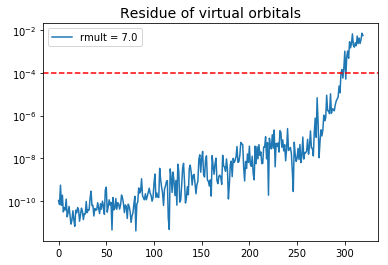

In [8]:
for r in range(len(rVal)):
    plt.plot(residues[r],label='rmult = '+str(rVal[r]))
plt.axhline(y=1e-4, color='r', linestyle='--')
plt.title('Residue of virtual orbitals',fontsize=14)
plt.yscale('log')
plt.legend()
plt.show()

On the basis of this plot we set the number of virtual orbitals with the chosen level of confidence

In [9]:
virtMax = []
errMax = 1e-4
for r in residues:
    notExcede = True
    i = 0
    while (notExcede):
        if r[i] > errMax:
            notExcede = False
        i+=1

    virtMax.append(i-2)
print 'virtMax = ', virtMax

virtMax =  [296]


To refine the result we perform the computation again (with a higher value of 'itermax_virt') and if needed we repeat the computation starting from the number of virtual orbitals that exceed the maximum allowed value:

In [75]:
r = 0
print 'Rmult = ', rVal[r]
virt_reduced = [304,320]
print virt_reduced

Rmult =  7.0
[304, 320]


In [76]:
inp={'dft':{'itermax_virt' : 50},
     'posinp': 'N2_posinp_rmult'+str(rVal[r])+'-pbc.xyz'}
inp['radical'] = 'Rmult_'+str(rVal[r])
lrun=[]
for n in virt_reduced:
    inp['dft']['norbv'] = -n
    inpname = 'Rmult_'+str(rVal[r])+'_numVirt_'+str(n)
    Yaml.dump(inp,outputpath + inpname + '.yaml')
    lrun.append(inpname)
Yaml.dump(lrun,outputpath+'runs_reduced_'+str(rVal[r]))

we execute againg the selected input files

In [59]:
code=C.SystemCalculator(omp=2,mpi=4)
%cd $outputpath
code.run(run_name='runs_reduced_'+str(rVal[r]),skip=True,outdir='./log/')
%cd ../

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2-pbc/virtual-orbitals
Executing command:  mpirun -np 4 $BIGDFT_ROOT/bigdft -r runs_reduced_7.0 -d ./log/
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2-pbc


We proceed with the refinement up to the choosen level of precision.

We observe that the last computation performed is the one with the highest number of virtual orbitals, so the orbitals written on file are associated to this log, and we have to refer to it in order to correctly attribute energy and other paramters associated to them.

## Scaling of the energy vs. number of virtual orbitals

We read data in the log associated to a specific number of virtual orbitals

In [10]:
Data = []
%cd $outputpath
for r in rVal:
    spath = 'log/log-Rmult_'+str(r)+'_numVirt_'+str(virt[-1])+'.yaml'
    log = !ls $spath
    print log
    Data.append(lf.Logfile(log[0]))
%cd ..

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2-pbc/virtual-orbitals
['log/log-Rmult_7.0_numVirt_320.yaml']
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2-pbc


We build the array with the energy of the empty orbitals, up to virtMax. Results are expressed in eV

In [11]:
numOccOrb = 5
engVirt = []
for r in range(len(rVal)):
    print 'Rmult = ', rVal[r], 'virtMax = ', virtMax[r]
    eVirt = 27.211*Data[r].evals[0][0][numOccOrb:numOccOrb+virtMax[r]]
    engVirt.append([e for e in eVirt])

Rmult =  7.0 virtMax =  296


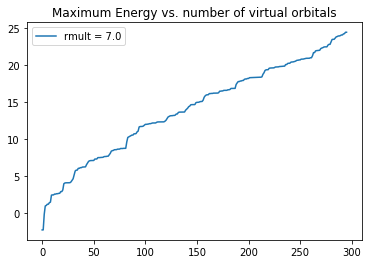

In [12]:
for r in range(len(rVal)):
    plt.plot(engVirt[r],label='rmult = '+str(rVal[r]))
plt.title('Maximum Energy vs. number of virtual orbitals',fontsize=12)
plt.legend()
plt.show()

In [67]:
# write engVirt for rmult = 7.0 on file
%cd $outputpath
#f = open('engVirt.txt','w')
#json.dump(engVirt[0],f)
#f.close()
%cd ../

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2-pbc/virtual-orbitals
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2-pbc
